In [2]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [20]:
#f = r.TFile("./data/gm2lostMuonTree_full_run2timingoffsets.root")
#f = r.TFile("./data/gm2offline_full_allSubruns.root") # energy ending at 1000
#f = r.TFile("./data/gm2offline_full_allRuns_EnergyFix.root")
#f = r.TFile("./data/gm2offline_full_26276471_29925.00031.root") #1 file with run3 templates
#f = r.TFile("./data/results_LostMuons_ForEnergyCalibration.root") #results of all lost muon runs with run3 templates.
f = r.TFile("./data/results_intermediateStage_1572files_mipRunPostDisk.root") #all files post disk run
f = r.TFile("./data/post_disk/gm2offline_full.root")
f = r.TFile("./data/post_disk/Jan10_withEnergyAndIntraAndInterCalib_energy_vs_xtal_vs_coinNum.root")
f.cd("lostMuonTree")
f.ls()

t = f.Get("lostMuonTree/lostMuonCoincidences")
#t.Print()

TFile**		./data/post_disk/Jan10_withEnergyAndIntraAndInterCalib_energy_vs_xtal_vs_coinNum.root	
 TFile*		./data/post_disk/Jan10_withEnergyAndIntraAndInterCalib_energy_vs_xtal_vs_coinNum.root	
  KEY: TCanvas	c1;1	c1


Error in <TFile::cd>: Unknown directory lostMuonTree


In [21]:
#cutString = "coinNum == 1 && nHit == 1" #original
#cutString = "coinNum == 3 && nHit == 1"

fin_hist = "./data/Dec18_energy_vs_xtal_vs_coinNum.root"
fin_hist = "./data/post_disk/Jan10_withEnergyAndIntraAndInterCalib_energy_vs_xtal_vs_coinNum.root"

coincidenceNumber = 2
#coincidenceNumber = [1,3]
singleCoincidence = True
printCaloHists = True
getHistFromFile = True #get hist from saves root file, not from TTree
highMeanAsError = True #if the mean of an xtal is above a certain error, flag the fit as bad


#cutString = "coinNum > 0 && coinNum < 4 && nHit == 1"
cutString = "coinNum == "+str(coincidenceNumber)+" && nHit == 1"

[<ROOT.TH3D object ("hist") at 0x7f0257ff5ad0>, <ROOT.TPaveText object ("title") at 0x7f0257fa9140>]


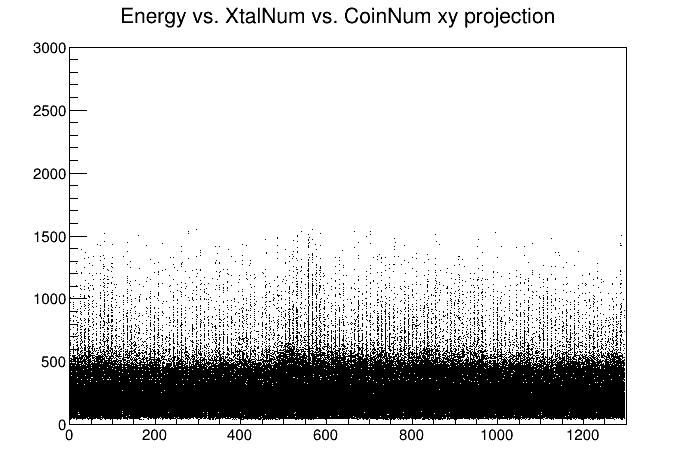

In [22]:
if(getHistFromFile):
    #fhist = r.TFile("./data/xtalEnergy_vs_XtalNum_ForEnergyCalibration.root")
    #c = fhist.Get("c1")
    #allEnergies = c.GetPrimitive("energyXtal").Clone("energyXtal")
    #allEnergies.SetDirectory(0)
    fhist = r.TFile(fin_hist)
    c = fhist.Get("c1")
    print([x for x in c.GetListOfPrimitives()])
    allEnergies_3D = c.GetPrimitive("hist").Clone("energyXtal_3D")
    allEnergies_3D.SetDirectory(0)
    if(singleCoincidence):
        allEnergies_3D.GetZaxis().SetRangeUser(coincidenceNumber,coincidenceNumber+0.1)
    else:
        allEnergies_3D.GetZaxis().SetRangeUser(coincidenceNumber[0],coincidenceNumber[1]+0.1)
    allEnergies = allEnergies_3D.Project3D("xy").Clone("energyXtal")
    allEnergies.SetDirectory(0)
else:
    allEnergies = r.TH2D("energyXtal","Xtal Energies; Xtal Number; Energy [MeV-ish]", 1296,-0.5,1295.5,400,0.0,3000.0)
    t.Draw("xtalEnergy:(caloNum-1)*54 + xtalNum>>energyXtal",cutString,"goff")

c = r.TCanvas()
allEnergies.Draw()
c.Draw()

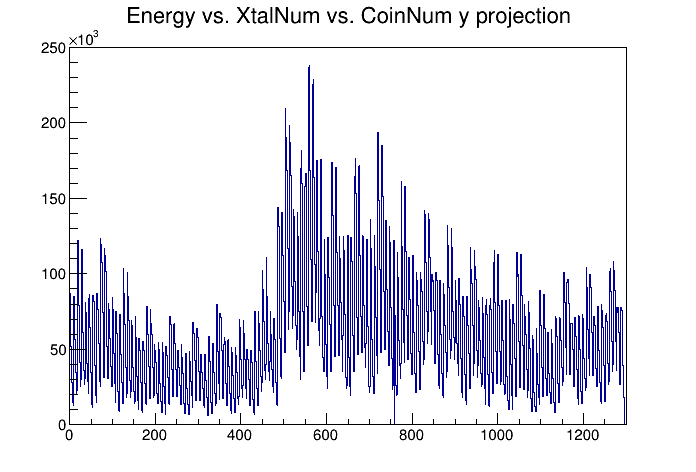

In [23]:
c = r.TCanvas()

#allEnergies_3D.GetYaxis().SetRangeUser(5,5)
#allEnergies_3D.Draw("lego2z")
histi = allEnergies_3D.Project3D("y")
histi.Draw("colz")

#c.SetLogy()
c.Draw()

77690630.0


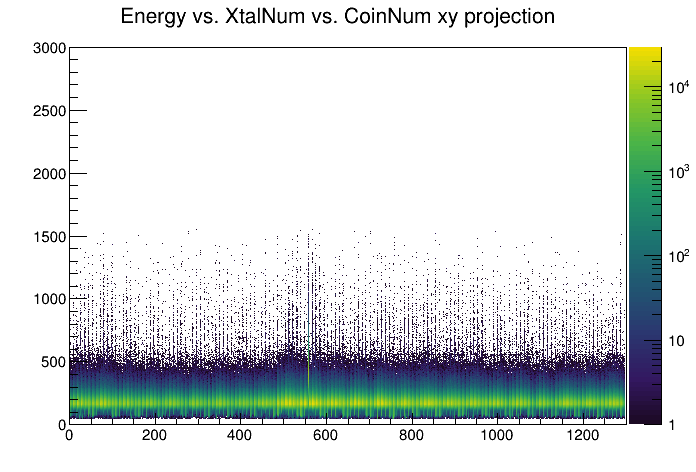

In [24]:
c = r.TCanvas()
allEnergies.Draw("colz")
print(allEnergies.GetEntries())
c.SetLogz()
c.Draw()

In [25]:
targetE = 170.0 #MeV
scales = []
runningCalo = []
potentialLostCauses = []

uncalibratedAllXtals = r.TH1D("uncalibratedAllXtals","All crystals",100,0.0,1000.0)
calibratedXtals = r.TH1D("calibratedXtals","All crystals; Energy [MeV]; N / 5 MeV",100,0.0,1000.0)
calibratedXtalsFinal = r.TH1D("calibratedXtalsFinal","All crystals; Energy [MeV]; N / 5 MeV",100,0.0,1000.0)

#current bad xtals
ding = [ #(36, 100, 800)
       ]

if(len(ding) > 0):
    problemXtals, lower, upper = zip(*ding)
else:
    problemXtals, lower, upper = ([],[],[])


if((len(problemXtals) != len(lower)) or (len(problemXtals) != len(upper)) or (len(upper) != len(lower))):
    print("WARNING! VECTORS HAVE DIFFERENT LENGTHS")


In [26]:
laserConstants = [0.3 for x in range(24*54)]

In [27]:
with open("./data/gains_iter20.txt") as file:
    for line in file:
        if("calo" in line):
            calo = int(line.split("calo")[1].split(" ")[0])
            #print(calo)
        if (("xtal" in line)):
            xtal = int(line.split("xtal")[1].split(" ")[0])
            constant = float(line.split("xtal")[1].split(" ")[2][:-1])
            laserConstants[(calo-1)*54 + xtal] = constant
            #print(xtal, contsant)

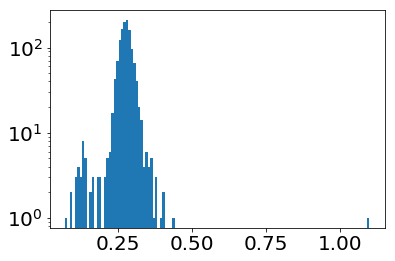

In [28]:
len(laserConstants)
plt.hist(laserConstants, bins=125)
plt.yscale("log")
plt.show()

In [29]:
print("Laser factor:", np.mean(laserConstants))
#laserFactor = 0.2749; #jasons value
laserFactor = np.mean(laserConstants); #calculated from the values brynn sent

Laser factor: 0.27381481481481484


In [30]:
projHist = allEnergies.ProjectionY("_py"+str(1),1,-1,"").Clone()
#projHist->Add(allEnergies.at(0)->ProjectionY(Form("_py%i",0),1,-1,""));
#projHist->Add(allEnergies.at(2)->ProjectionY(Form("_py%i",2),1,-1,""));
tempMean = projHist.GetMean()
tempSig = projHist.GetRMS()
binmax = projHist.GetMaximumBin()
peak = projHist.GetXaxis().GetBinCenter(binmax)
projHist.Fit("gaus","Q","",peak-75, peak+75)

avgPeak = peak;

scaleFactor = targetE / projHist.GetFunction("gaus").GetParameter(1)
print( "average calibration constant is : " , scaleFactor )

for k in range( 1,projHist.GetXaxis().GetNbins() ):
    uncalibratedAllXtals.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                              projHist.GetBinContent(k))

average calibration constant is :  0.9853245188088863


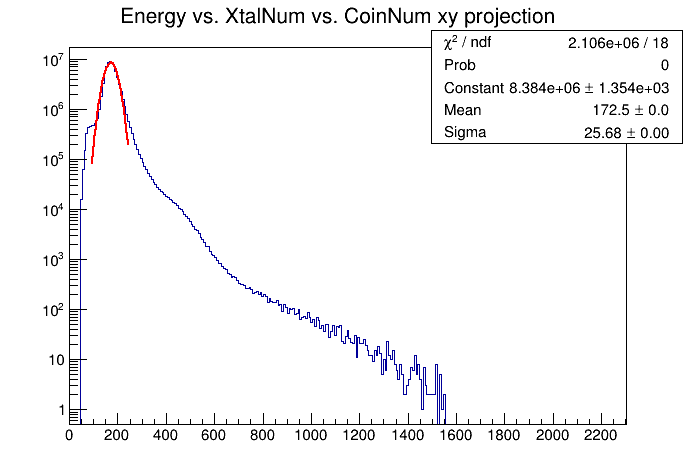

In [31]:
c = r.TCanvas()
projHist.Draw()
projHist.GetXaxis().SetRangeUser(0,2300)
c.SetLogy()
c.Draw()

---

In [32]:
caloLow = 1
caloHigh = 24

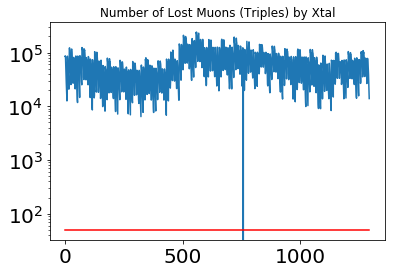

In [33]:
nMuons = []
xtalsBelowThreshold = []
for xIdx in range( (caloLow-1)*54+1 , caloHigh*54+1 ):
    #print("Starting crystal", xIdx)
    #projHist.Clear();
    #projHist=allEnergies.ProjectionY("_py"+str(xIdx*10+0),xIdx,xIdx,"").Clone()
    projHist = allEnergies.ProjectionY("_py",xIdx,xIdx,"").Clone("py")
    nMuons.append(projHist.GetEntries())
    if(projHist.GetEntries() <= 50):
        xtalsBelowThreshold.append(xIdx)
    projHist.Delete()
plt.plot(nMuons)
plt.yscale("log")
plt.plot([0,1296], [50,50], "r")
plt.title("Number of Lost Muons (Triples) by Xtal")
plt.show()

In [34]:
#print(xtalsBelowThreshold)
print("Crystals below threshold of 50 mips:")
for x in xtalsBelowThreshold:
    print("   - calo", int(np.ceil(x/54)), "xtal", x%54-1)
    potentialLostCauses.append(x-1)

Crystals below threshold of 50 mips:
   - calo 15 xtal 2


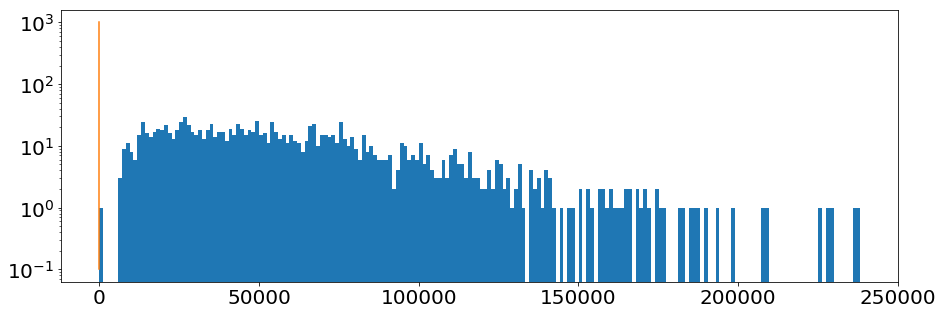

In [35]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(nMuons,bins=200)#, range=(0,100))
plt.plot([50,50],[0.1,1000])
plt.yscale("log")
plt.show()

In [36]:
c2 = r.TCanvas("c2","c2",1800,1200);

#for(int xIdx = (caloLow-1)*54 + 1; xIdx <= caloHigh*54; xIdx++){//allEnergies.at(0)->GetXaxis()->GetNbins()
#for xIdx in range( (caloLow-1)*54 + 1, caloHigh*54 ):

energyMinFit = 50.
energyMaxFit = 3000.

allFitHists = [ np.nan for x in range(54*24) ]

scales = [np.nan for x in range(54*24)]

for xIdx in range( (caloLow-1)*54+1 , caloHigh*54+1 ): #this is the bin index, not the crystal number
    print("Starting crystal", xIdx - 1)
    #projHist.Clear();
    #projHist=allEnergies.ProjectionY("_py"+str(xIdx*10+0),xIdx,xIdx,"").Clone()
    projHist = allEnergies.ProjectionY("_py",xIdx,xIdx,"").Clone("py")
    projHist.SetTitle("Xtal "+str(xIdx - 1)+" (calo "+str(int(np.ceil((xIdx-1) / 54)))+", xtal "+str((xIdx - 1) % 54)+")")
    #for(int hit = 1; hit < allEnergies.size(); hit++){
    #    projHist->Add(allEnergies.at(hit)->ProjectionY(Form("_py%i",xIdx*10+hit),xIdx,xIdx,""));
    #}


    #projHist = allEnergies->ProjectionY(Form("_py%i",xIdx),xIdx,xIdx,"");
    #projHist->Rebin(4);

    if(projHist.GetEntries() > 50):
        
        tempMean = projHist.GetMean();
        tempSig = projHist.GetRMS();
        binmax = projHist.GetMaximumBin();
        peak = projHist.GetXaxis().GetBinCenter(binmax);
        peakValue = projHist.GetBinContent(binmax);
        
        while(peakValue < 50):
            #print("hi")
            projHist.Rebin(2);
            binmax = projHist.GetMaximumBin();
            peak = projHist.GetXaxis().GetBinCenter(binmax);
            peakValue = projHist.GetBinContent(binmax);
        #print("continuing")
                                                                
        mini = min([energyMinFit,peak - 60]);
        maxi = max([energyMaxFit,peak + 60]);

        #if(std::find(problemXtals.begin(),problemXtals.end(),xIdx-1)!=problemXtals.end()):
        problemXtal = False
        if( xIdx-1 in problemXtals ):
            problemXtal = True
            #pos = std::find(problemXtals.begin(),problemXtals.end(),xIdx-1) - problemXtals.begin();
            pos = problemXtals.index( xIdx - 1 )
            mini = lower[pos];
            maxi = upper[pos];
            print("     Problem xtal", xIdx - 1)

        #print("fitting")
        
        #define new function in order to set limits
        func = r.TF1("gaus","gaus")
        func.SetParameters(1,500,1)
        func.SetParLimits(0,0,10000000)
        func.SetParLimits(1,100,3000)
        
        for thisMacroSucks in range(2):
            #projHist.Fit("gaus","RQ","",mini, maxi);
            projHist.Fit(func,"RQ","",mini, maxi);
        #if(not problemXtal):
        print("     ",mini, maxi)
        mini = max([energyMinFit,projHist.GetFunction("gaus").GetParameter(1) - 1.5*projHist.GetFunction("gaus").GetParameter(2)]);
        maxi = min([energyMaxFit,projHist.GetFunction("gaus").GetParameter(1) + 1.4*projHist.GetFunction("gaus").GetParameter(2)]);
        #delete projHist->GetFunction("gaus");
        print("     ",mini, maxi)
        #projHist.Fit("gaus","RQ","",mini, maxi);
        projHist.Fit(func,"RQ","",mini, maxi);
        #print("endfitting")
        runningCalo.append(projHist);
        scaleFactor = targetE / projHist.GetFunction("gaus").GetParameter(1);
        #scales.append(scaleFactor);
        scales[xIdx - 1] = scaleFactor
        allFitHists[xIdx - 1] = projHist.Clone("h_"+str(xIdx - 1))
        
        for k in range(1, projHist.GetXaxis().GetNbins() ):
            calibratedXtals.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                                 projHist.GetBinContent(k));

    else:
        print( "Not enough events in channel : " , xIdx) 
        scales[xIdx - 1] = 1.0
        runningCalo.append(projHist);
        allFitHists[xIdx - 1] = projHist.Clone("h_"+str(xIdx - 1))

Starting crystal 0
      50.0 3000.0
      108.64431549318964 213.36416873957785
Starting crystal 1
      50.0 3000.0
      123.05780417695888 212.5669386474691
Starting crystal 2
      50.0 3000.0
      122.23034620433882 213.0459777081494
Starting crystal 3
      50.0 3000.0
      124.5563709183931 212.03125890472367
Starting crystal 4
      50.0 3000.0
      129.94081279749176 209.30134051507417
Starting crystal 5
      50.0 3000.0
      133.96035978489834 207.47643780333075
Starting crystal 6
      50.0 3000.0
      135.5727313014494 207.01509984948387
Starting crystal 7
      50.0 3000.0
      133.79601128051564 209.15972137445448
Starting crystal 8
      50.0 3000.0
      126.30244693410077 211.81110515869904
Starting crystal 9
      50.0 3000.0
      127.7628047590137 212.64096447024434
Starting crystal 10
      50.0 3000.0
      137.68521762745206 206.93070830720518
Starting crystal 11
      50.0 3000.0
      138.1736432738077 207.40902899221757
Starting crystal 12
      50.0 3

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


In [37]:
print(allFitHists[:5],"...", allFitHists[-5:])

[<ROOT.TH1D object ("h_0") at 0x7f0257f10840>, <ROOT.TH1D object ("h_1") at 0x7fffe5601bd0>, <ROOT.TH1D object ("h_2") at 0x7fffe5526300>, <ROOT.TH1D object ("h_3") at 0x7f0257f12c60>, <ROOT.TH1D object ("h_4") at 0x7fffe5911480>] ... [<ROOT.TH1D object ("h_1291") at 0x7f024b603f10>, <ROOT.TH1D object ("h_1292") at 0x7f024b60b0a0>, <ROOT.TH1D object ("h_1293") at 0x7f024b612330>, <ROOT.TH1D object ("h_1294") at 0x7f024b619460>, <ROOT.TH1D object ("h_1295") at 0x7f024b620430>]


Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24


Info in <TCanvas::Print>: png file ./images/AllFits_Calo01.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo01.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo02.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo02.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo03.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo03.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo04.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo04.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo05.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo05.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo06.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo06.root has been created
Info in <TCanvas::Prin

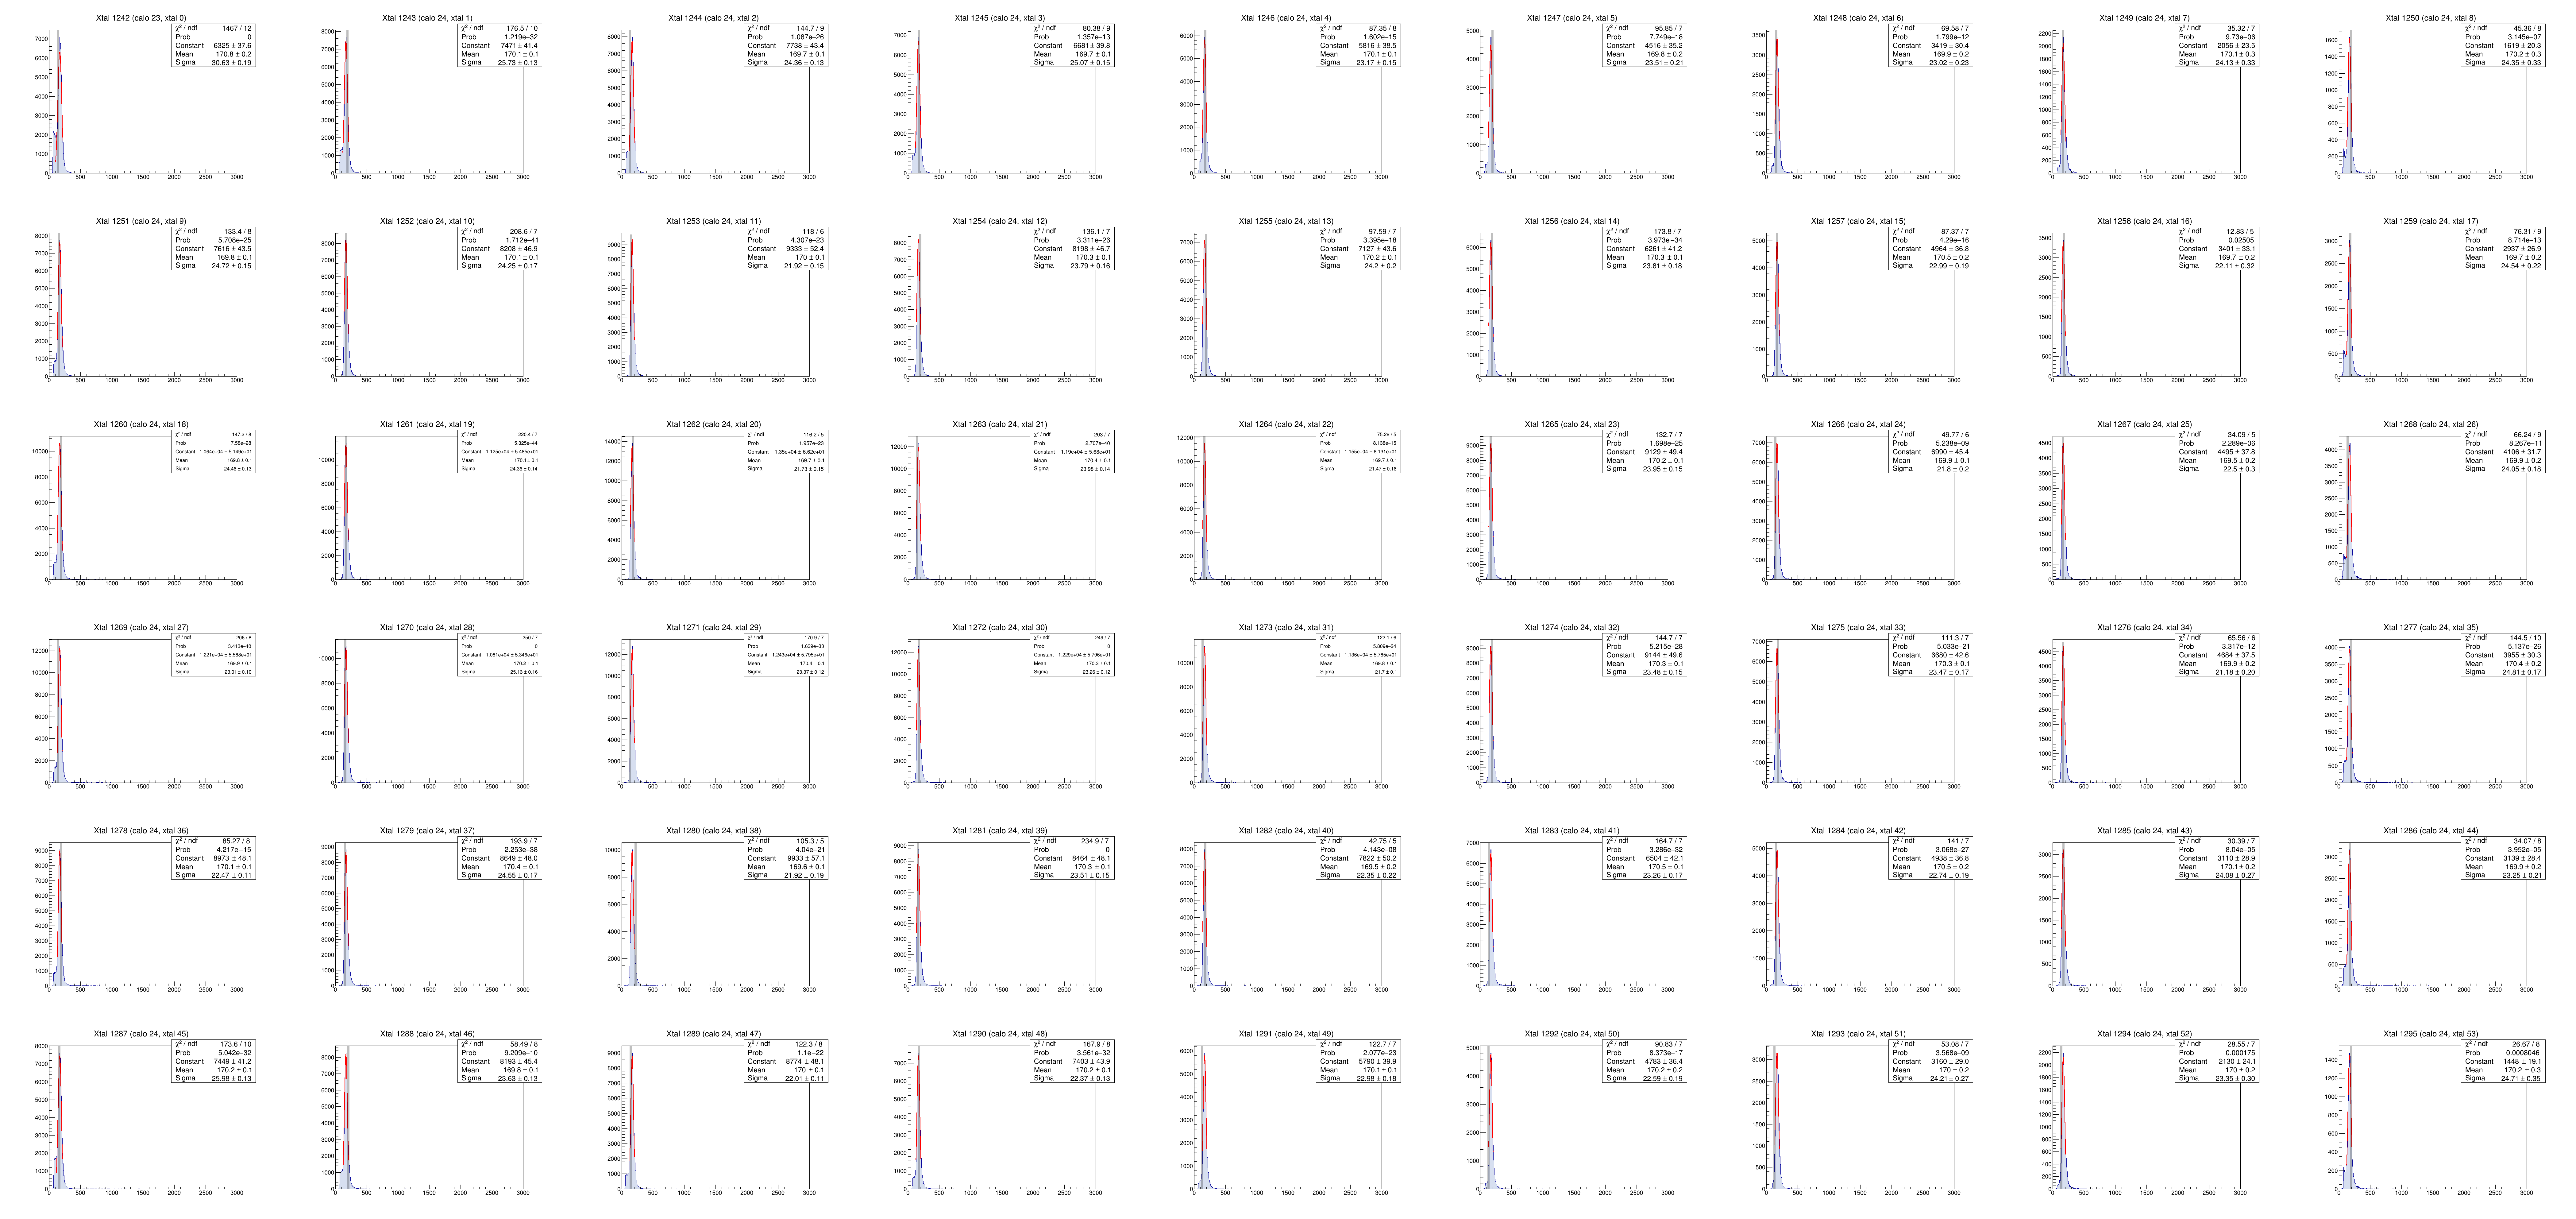

In [38]:
c = r.TCanvas("c","c", 8400, 4000)
c.Divide(9,6)
lines = [-1 for i in range(len(allFitHists))]
for i, h in enumerate(allFitHists):
    #if(i > 3):
    #    break
    #print((i%54) + 1)
    
    c.cd((i%54) + 1 )
    try:
        h.SetFillColorAlpha(38,0.3)
        h.Draw()
        peakValue = h.GetBinContent(h.GetMaximumBin())
        xValue = avgPeak * laserFactor / laserConstants[i]
        line1 = r.TLine( xValue, 0, xValue , 1.05*peakValue);
        line1.SetLineColorAlpha(1,0.25);
        line1.SetLineWidth(7)
        lines[i] = line1.Clone("line_"+str(i))
        lines[i].Draw()
        
    except:
        print("Error: no histogram in entry", i)
        #continue
        

    if( i % 54 == 53):
        print("Starting calo", int(np.ceil(i/54)))
        if(printCaloHists):
            c.Draw()
            c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".png")
            #c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".pdf")
            c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".root")

c.Draw()

In [39]:
fitPars = [ np.nan for i in range(24*54) ]
for i, h in enumerate(allFitHists):
    try:
        fitPars[i] = (
            h.GetFunction("gaus").GetParameter(0),
            h.GetFunction("gaus").GetParError(0) ,
            h.GetFunction("gaus").GetParameter(1),
            h.GetFunction("gaus").GetParError(1),
            h.GetFunction("gaus").GetParameter(2),
            h.GetFunction("gaus").GetParError(2),
            h.GetFunction("gaus").GetChisquare(),
            h.GetFunction("gaus").GetNDF() 
        )
    except:
        fitPars[i] = [np.nan for x in range(8)]
        print("Error: no histogram in", i)

Error: no histogram in 758


(8768.094191688448, 27.59052266404524, 414.47583586637944, 0.1976431043227933, 69.07748550330632, 0.22077294723822405, 320.95506813290274, 29)
542 bad fits


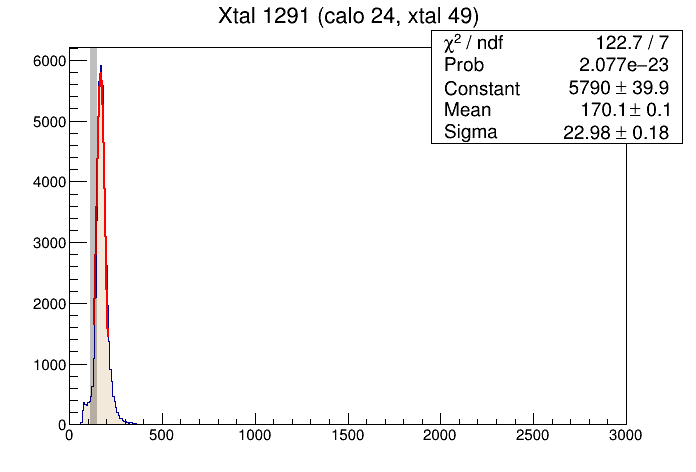

In [40]:
badFits = []
os.system("rm -f ./images/BadFit*")
c = r.TCanvas()
chiSqCut = 15
chiSqCutLow = 0.91
for i, x in enumerate(fitPars):
    if(i == 558):
        print(x)
    if(x[7] != 0):
        if(x[6]/x[7] > chiSqCut or not(x[6]/x[7] > chiSqCutLow) or x[2] < 101):
            allFitHists[i].Draw("")
            allFitHists[i].SetFillColorAlpha(42,0.3)
            lines[i].Draw("SAME")
            c.Draw()
            #c.Print("./images/BadFit_"+str(i).zfill(4)+".png")
            #print("Bad fit in xtal", i)
            badFits.append(i)
    else:
        badFits.append(i)
            
print(len(badFits),"bad fits")

In [41]:
print(badFits)

[0, 1, 5, 9, 10, 11, 14, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 36, 37, 38, 39, 40, 41, 45, 46, 54, 56, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 81, 82, 84, 86, 90, 91, 92, 94, 95, 99, 100, 103, 108, 118, 119, 126, 127, 128, 129, 135, 136, 137, 138, 143, 146, 147, 153, 162, 171, 173, 174, 180, 182, 183, 189, 190, 191, 192, 199, 200, 201, 202, 205, 207, 216, 234, 235, 243, 244, 254, 258, 261, 270, 279, 280, 288, 289, 290, 291, 297, 298, 310, 315, 324, 334, 335, 337, 342, 344, 346, 351, 352, 353, 354, 357, 360, 369, 378, 389, 397, 399, 400, 407, 408, 414, 423, 432, 441, 442, 443, 444, 450, 451, 453, 459, 461, 462, 467, 469, 470, 471, 477, 486, 487, 488, 490, 492, 495, 496, 497, 498, 499, 500, 501, 502, 504, 505, 506, 507, 508, 509, 510, 513, 514, 515, 516, 517, 518, 519, 522, 523, 524, 525, 526, 527, 528, 529, 531, 532, 534, 535, 536, 540, 541, 542, 543, 544, 545, 549, 550, 551, 552, 553, 554, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574,

In [42]:
const, constErrs, means, meanErrs, sigs, sigErrs, chiSq, ndf = zip(*fitPars)
xtalNums = [i for i in range(len(const))]

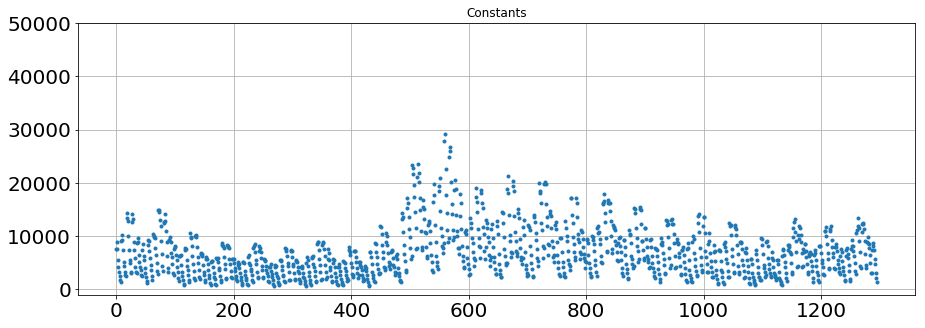

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title("Constants")
plt.errorbar(xtalNums, const, yerr=constErrs, fmt=".")
plt.ylim(-1000,50000)
plt.grid()
plt.show()

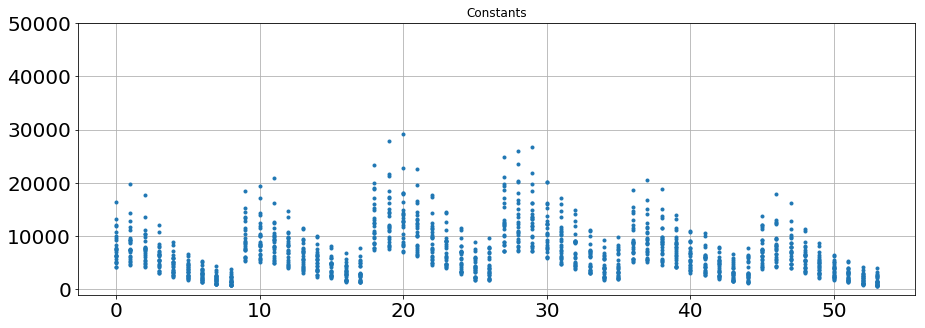

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title("Constants")
plt.errorbar([x % 54 for x in xtalNums], const, yerr=constErrs, fmt=".")
plt.ylim(-1000,50000)
plt.grid()
plt.show()

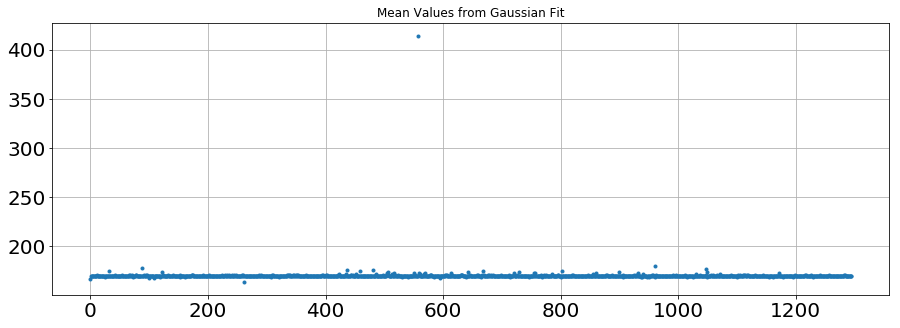

Crystals with high mean values ( > 750 MeV): []


In [45]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, means, yerr=meanErrs, fmt=".")
plt.grid()
plt.title("Mean Values from Gaussian Fit")
plt.show()

highMeans = []
for i, x in enumerate(means):
    if(x > 750):
        highMeans.append(i)
print("Crystals with high mean values ( > 750 MeV):", highMeans)

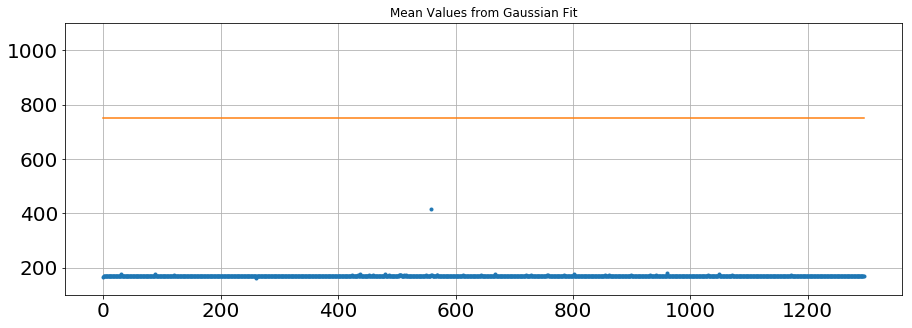

Crystals with high mean values ( > 750 MeV): []


In [46]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, means, yerr=meanErrs, fmt=".")
plt.grid()
plt.title("Mean Values from Gaussian Fit")
plt.ylim(100,1100)
meanLimit = 750
plt.plot([0,1296], [meanLimit, meanLimit])
plt.show()

highMeans = []
for i, x in enumerate(means):
    if(x > 750):
        highMeans.append(i)
        if(highMeanAsError and i not in badFits):
            badFits.append(i)
print("Crystals with high mean values ( > 750 MeV):", highMeans)

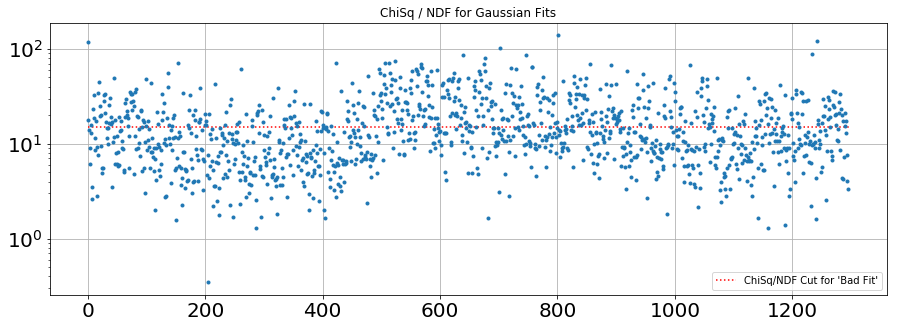

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, [x/(y+0.001) for (x,y) in zip(chiSq, ndf)], yerr=0, fmt=".")
plt.plot([0, 1296],[chiSqCut, chiSqCut], "r:", label="ChiSq/NDF Cut for 'Bad Fit'")
plt.title("ChiSq / NDF for Gaussian Fits")
plt.grid()
plt.legend()
plt.yscale("log")
plt.show()

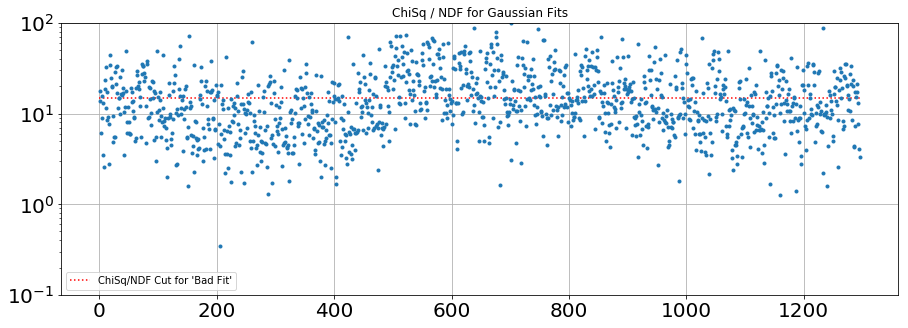

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, [x/(y+0.001) for (x,y) in zip(chiSq, ndf)], yerr=0, fmt=".")
plt.plot([0, 1296],[chiSqCut, chiSqCut], "r:", label="ChiSq/NDF Cut for 'Bad Fit'")
plt.title("ChiSq / NDF for Gaussian Fits")
plt.grid()
plt.legend()
plt.yscale("log")
plt.ylim(0.1,100)
plt.show()

---

### Many of the bad fids appear to be because of multiple peaks, lets use a peak finding algorithm like TSpectrum to try to identify them

We could also just use a double/triple gaussian fit, which will be plan B if this option fails / doesn't produce convincing results

ERROR: No peaks found in xtal 758


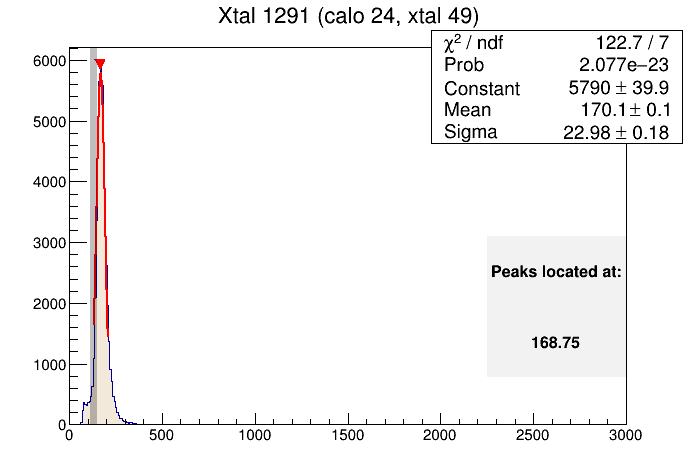

In [49]:
#i = 1007
#i = 1061
#i = 1124

badFitPeaks = []

os.system("rm -f ./images/TSpec*")
for i in badFits:
    c = r.TCanvas()
    allFitHists[i].Draw()
    spec = r.TSpectrum(6) #create a TSpectrum object to search for the peaks with
    npeaks = spec.Search(allFitHists[i], 
                2,      #sigma, see manual
                "",     #options
                0.05)   #threshold as a fraction of highest peak, only look for peaks which are comperable in size.
    #print("Found", npeaks, "peaks")
    #print("Peaks:", [spec.GetPositionX()[x] for x in range(npeaks)])
    spec.Draw("SAME")
    lines[i].Draw("SAME")
    c.Draw()
    #text = r.TPaveText(2000,100,3000,500,"")
    text = r.TPaveText(.7,.2,.9,.5,"NDC")
    text.AddText("Peaks located at:")
    for x in range(npeaks):
        text.AddText(str(spec.GetPositionX()[x]))
    if(npeaks == 0):
        print("ERROR: No peaks found in xtal", i)
        text.AddText("No peaks found")
        potentialLostCauses.append(i)
    text.Draw("SAME")
    
    badFitPeaks.append( (i, 
                         [spec.GetPositionX()[x] for x in range(npeaks)], 
                         [spec.GetPositionY()[x] for x in range(npeaks)]))
    
    #c.Print("./images/TSpectrum_"+str(i).zfill(4)+".png")
    #c.Print("./images/TSpectrum_"+str(i).zfill(4)+".root")

Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24


Info in <TCanvas::Print>: png file ./images/AllFits_PostTSpectrum_Calo01.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_PostTSpectrum_Calo01.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_PostTSpectrum_Calo02.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_PostTSpectrum_Calo02.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_PostTSpectrum_Calo03.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_PostTSpectrum_Calo03.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_PostTSpectrum_Calo04.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_PostTSpectrum_Calo04.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_PostTSpectrum_Calo05.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_PostTSpectrum_Calo05.root has been created
Info in <TCanvas::Print>: png file ./images/A

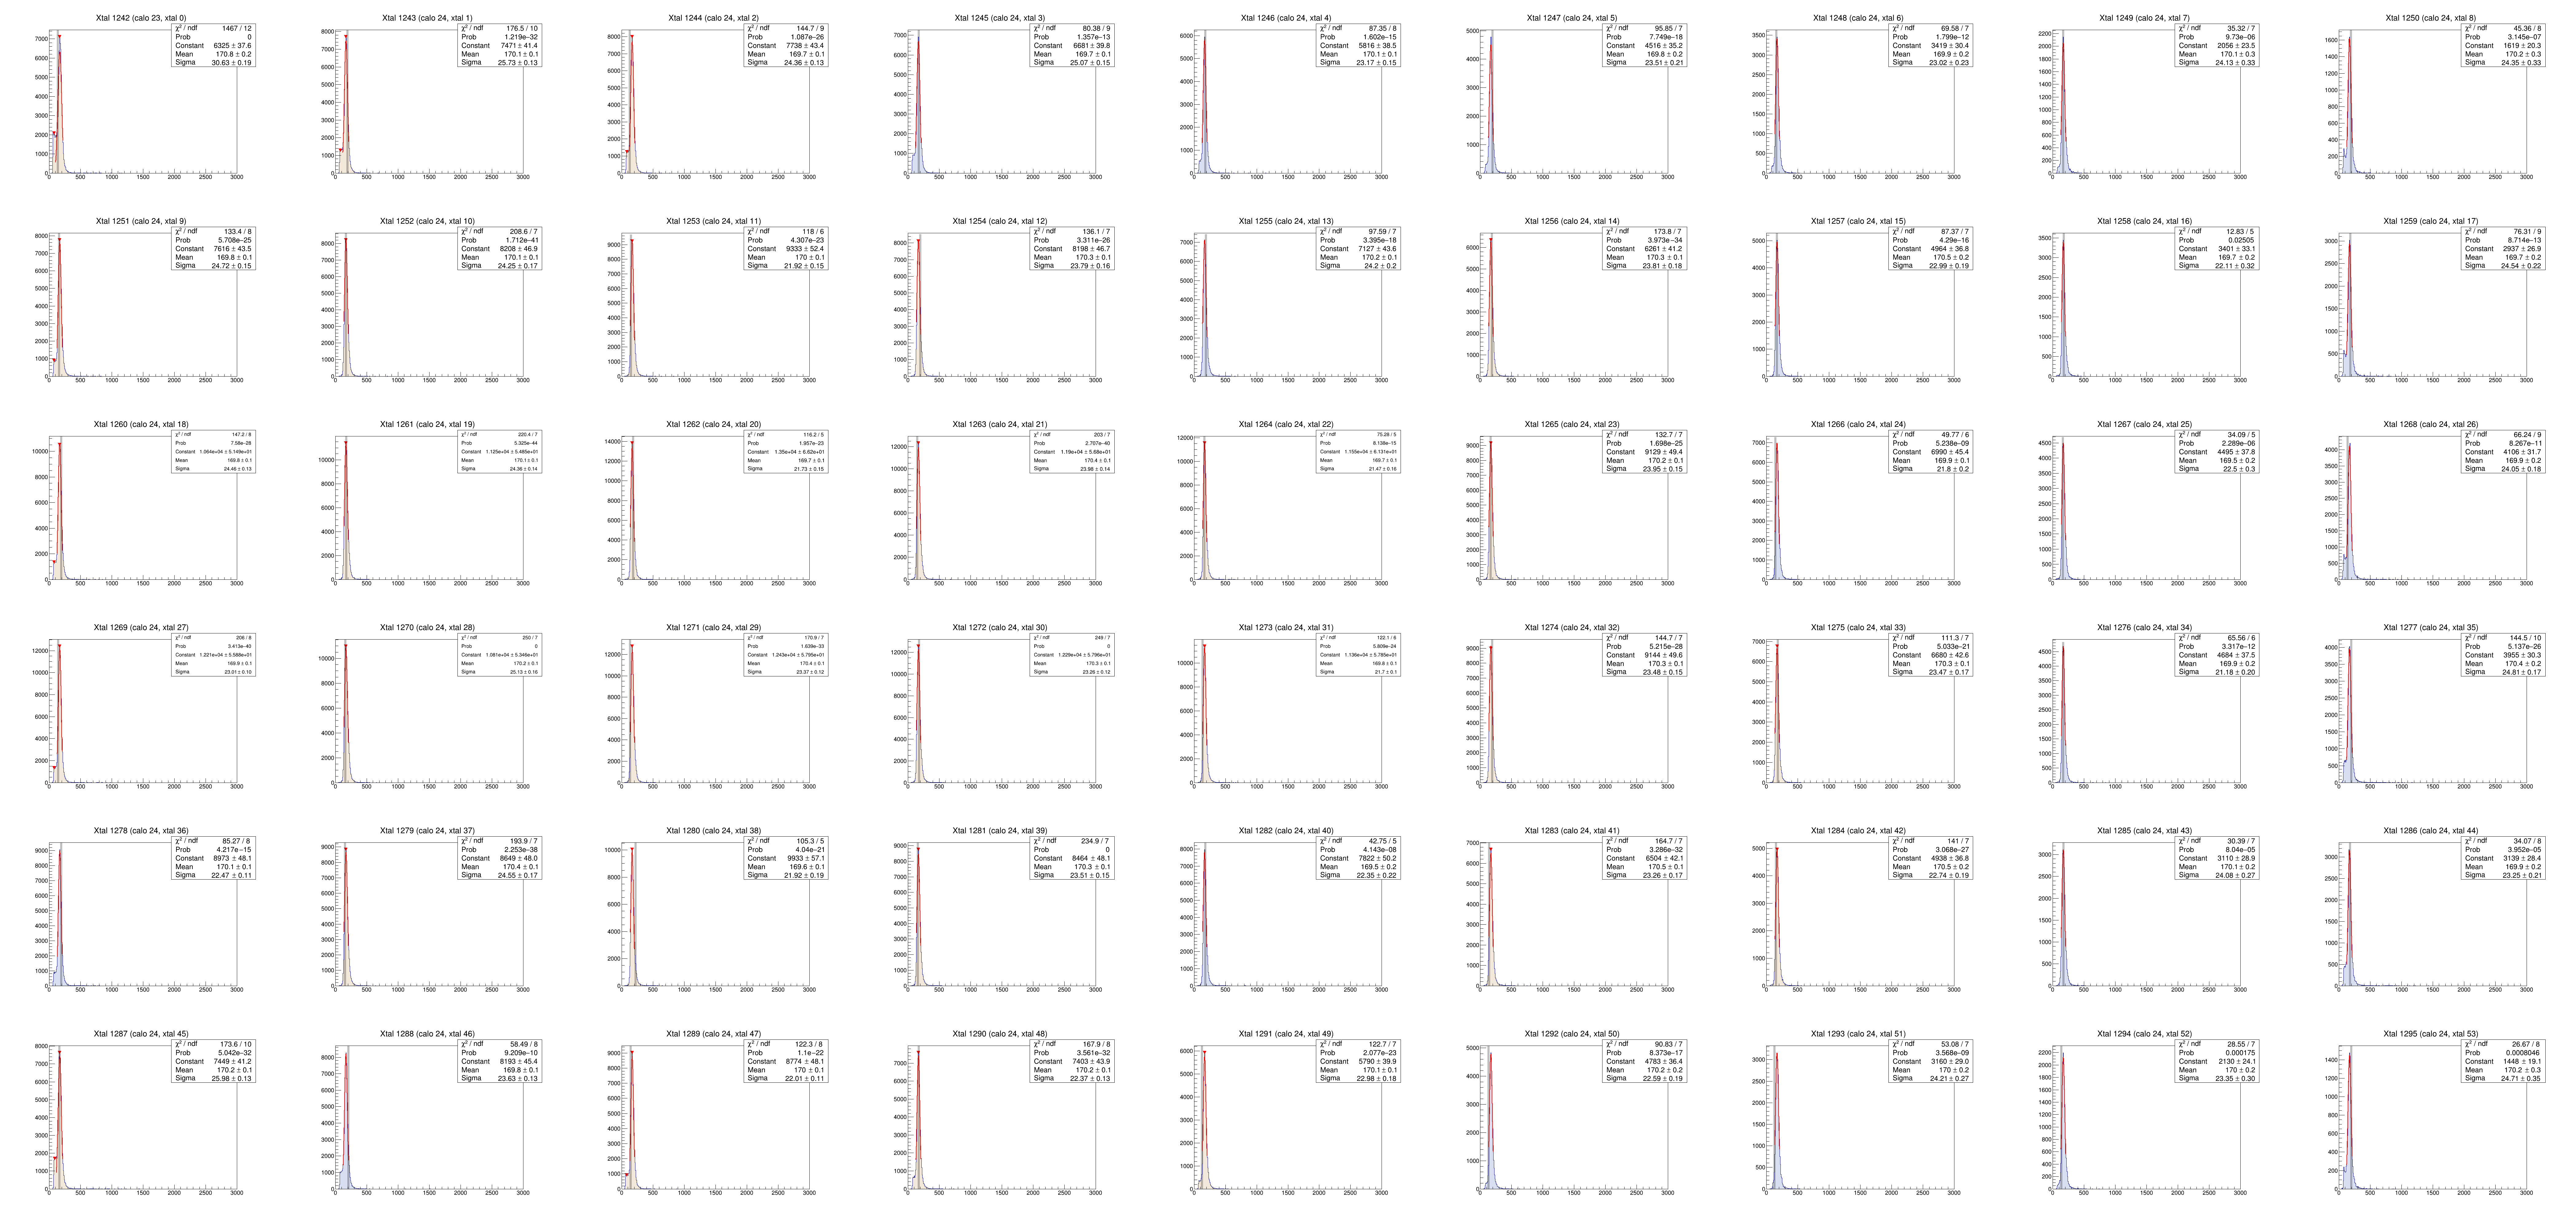

In [50]:
c = r.TCanvas("c","c", 8400, 4000)
c.Divide(9,6)

os.system("rm -f ./images/AllFits_PostTSpectrum_*")

for i, h in enumerate(allFitHists):
    c.cd((i%54) + 1 )
    try:
        #h.SetFillColorAlpha(38,0.3)
        h.Draw()
        lines[i].Draw()
        
    except:
        print("Error: no histogram in entry", i)
        #continue
        

    if( i % 54 == 53):
        print("Starting calo", int(np.ceil(i/54)))
        c.Draw()
        if(printCaloHists):
            c.Print("./images/AllFits_PostTSpectrum_Calo"+str(int(np.ceil(i/54))).zfill(2)+".png")
            c.Print("./images/AllFits_PostTSpectrum_Calo"+str(int(np.ceil(i/54))).zfill(2)+".root")

In [51]:
#fit function
'''
Double_t fpeaks(Double_t *x, Double_t *par) {
   Double_t result = par[0] + par[1]*x[0];
   for (Int_t p=0;p<npeaks;p++) {
      Double_t norm  = par[3*p+2];
      Double_t mean  = par[3*p+3];
      Double_t sigma = par[3*p+4];
      result += norm*TMath::Gaus(x[0],mean,sigma);
   }
   return result;
}
'''

def fpeaks(x,p):
    result = p[0] + p[1]*x[0]
    #print(len(p), (len(p) -2) / 3 )
    for i in range(int((len(p) -2) /3)):
        norm = p[3*i+2]
        mean = p[3*i+3]
        sigma = p[3*i+4]
        result += norm*r.TMath.Gaus(x[0], mean, sigma)
    return result

---

### Now lets use these peaks to decide the energy calibration for these crystals.

Initial plan is to take the largest amplitude peak if no other peak is a certain amount (maybe 75%?). If there are two+ peaks of comperable amplitude, then take the higher energy of the them (and flag for manual review).

In [52]:
peakCutoffFactor = 0.75

xtalsForReview = []
newLines = [-1 for x in range(54*24)]

os.system("rm -f ./images/Review*")

for j, (i, peakX, peakY) in enumerate(badFitPeaks):
    print("Starting xtal", i )
    if(len(peakY) > 0):
        maxPeak = max(peakY)
        maxPeakIndex = peakY.index(maxPeak)
        otherPeaks = []
        for k, pk in enumerate(peakY):
            if(pk < maxPeak and pk > peakCutoffFactor*maxPeak):
                otherPeaks.append(k)
        if(len(otherPeaks) > 1000):
            #for peaks in [maxPeakIndex]+[otherPeaks]:
            #    if(peakX[peak] > max(peakX)):
            #        finalPeak = 
            finalPeak = 0 #peakX[ peakX.index(max(peakX)) ]
            for k, pxk in enumerate(peakX):
                if(peakY[k] > peakCutoffFactor*maxPeak):
                    if(pxk > finalPeak): 
                        finalPeak = pxk
            print("     *** FLAG FOR REVIEW ***")
            xtalsForReview.append(i)
        else:
            finalPeak = peakX[maxPeakIndex]
        print("     Final peak for xtal", i, "=", finalPeak)
        print("    ", 
              finalPeak, 
              otherPeaks, 
              peakX,
              peakY )
        
        line1 = r.TLine( finalPeak, 0, finalPeak , 1.05*maxPeak);
        line1.SetLineColorAlpha(1,0.25);
        line1.SetLineWidth(7)
        newLines[i] = line1.Clone("line_"+str(i))
        c = r.TCanvas()
        allFitHists[i].Draw()
        newLines[i].Draw("SAME")
        c.Print("./images/ReviewHist_"+str(i).zfill(4)+".png")
        
        scaleFactor = targetE / finalPeak
        scales[i] = scaleFactor
        
    else:
        print("     No peaks found")
        potentialLostCauses.append(i)

Starting xtal 0
     Final peak for xtal 0 = 168.75
     168.75 [] [168.75, 78.75] [8257.0, 1941.0]
Starting xtal 1
     Final peak for xtal 1 = 168.75
     168.75 [] [168.75, 78.75] [9272.0, 1453.0]
Starting xtal 5
     Final peak for xtal 5 = 168.75
     168.75 [] [168.75] [3296.0]
Starting xtal 9
     Final peak for xtal 9 = 168.75
     168.75 [] [168.75] [9276.0]
Starting xtal 10
     Final peak for xtal 10 = 168.75
     168.75 [] [168.75] [10527.0]
Starting xtal 11
     Final peak for xtal 11 = 168.75
     168.75 [] [168.75] [9490.0]
Starting xtal 14
     Final peak for xtal 14 = 168.75
     168.75 [] [168.75] [4678.0]
Starting xtal 18
     Final peak for xtal 18 = 168.75
     168.75 [] [168.75] [13673.0]
Starting xtal 19
     Final peak for xtal 19 = 168.75
     168.75 [] [168.75] [14582.0]
Starting xtal 20
     Final peak for xtal 20 = 168.75
     168.75 [] [168.75] [13129.0]
Starting xtal 21
     Final peak for xtal 21 = 168.75
     168.75 [] [168.75] [10330.0]
Starting xtal 22

Info in <TCanvas::Print>: png file ./images/ReviewHist_0000.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0001.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0005.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0009.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0010.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0011.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0014.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0018.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0019.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0020.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0021.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0022.png has been created
Info in <TCanvas::Print>: pn

In [53]:
potentialLostCauses += [558]

In [54]:
print("Review these", len(xtalsForReview),"xtals:", xtalsForReview)
print("Potential lost causes:", potentialLostCauses)

Review these 0 xtals: []
Potential lost causes: [758, 758, 758, 558]


---

### Some crystals may fail even after this step. These we can set manually

[558, 758]


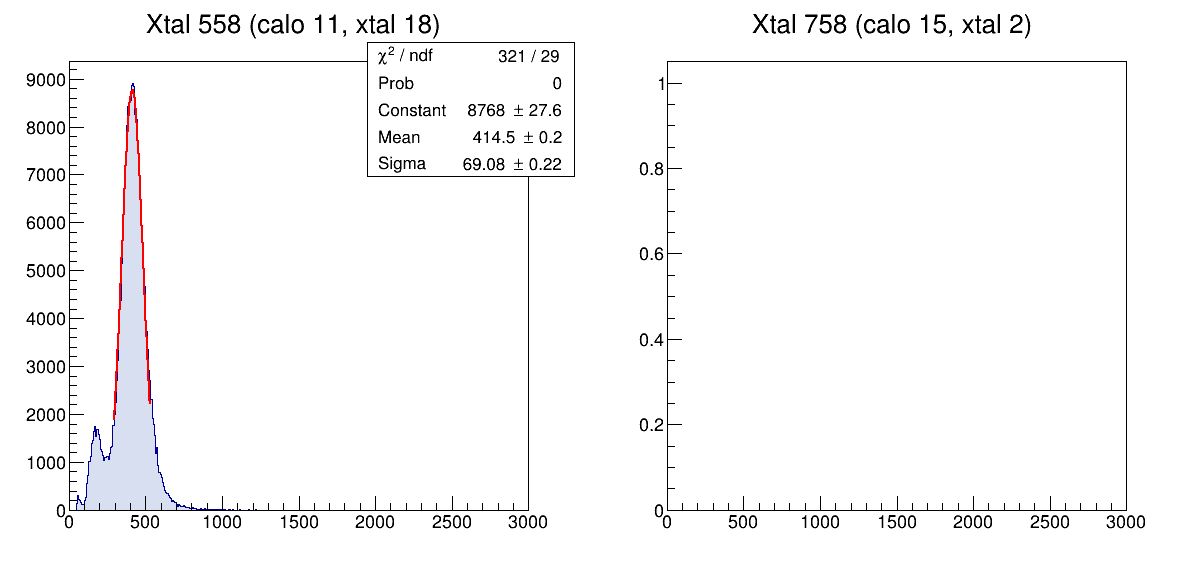

In [55]:
potentialLostCauses = list(set(potentialLostCauses))
print(potentialLostCauses)
c = r.TCanvas("c","c",600*len(potentialLostCauses), 600)
c.Divide(len(potentialLostCauses))
for i, x in enumerate(potentialLostCauses):
    c.cd(i+1)
    allFitHists[x].Draw()
c.Draw()

In [56]:
lostCauses = []

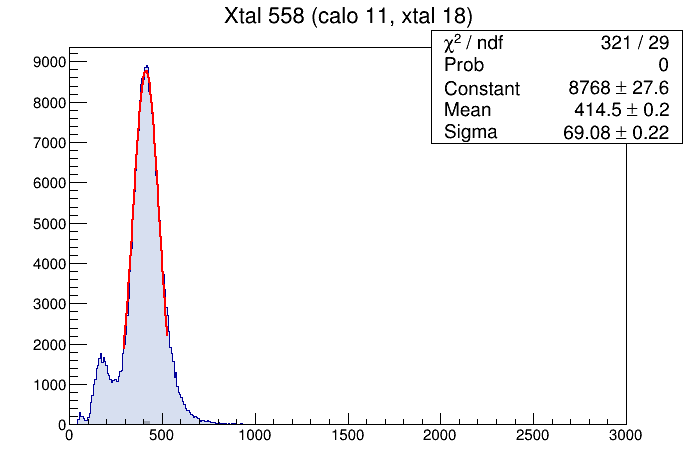

In [57]:
i = potentialLostCauses[0]
c = r.TCanvas()
allFitHists[i].Draw()

#finalPeak = allFitHists[i].GetBinCenter( allFitHists[i].GetMaximumBin() )
finalPeak = allFitHists[i].GetFunction("gaus").GetParameter(1)

lostCauses.append((i, 
                   finalPeak))
line1 = r.TLine( finalPeak, 0, finalPeak , 70);
line1.SetLineColorAlpha(1,0.25);
line1.SetLineWidth(7)
line1.Draw("SAME")

c.Draw()

In [58]:
print(lostCauses)
for i, const in lostCauses:
    scaleFactor = targetE / const
    scales[i] = scaleFactor

[(558, 414.47583586637944)]


---

In [59]:
for i, x in enumerate(allFitHists):
    if("ROOT" not in str(type(x))):
        print(i,x)

In [60]:
calibratedXtalsFinal = calibratedXtals.Clone("calibratedXtalsFinal")
calibratedXtalsFinal.Reset()
calibratedXtalsFinal.SetLineColor(3)
for i, projHist in enumerate(allFitHists):
    scaleFactor = scales[i]
    for k in range(1, projHist.GetXaxis().GetNbins() ):
        calibratedXtalsFinal.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                             projHist.GetBinContent(k));

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file ./images/calibrationComparison.png has been created


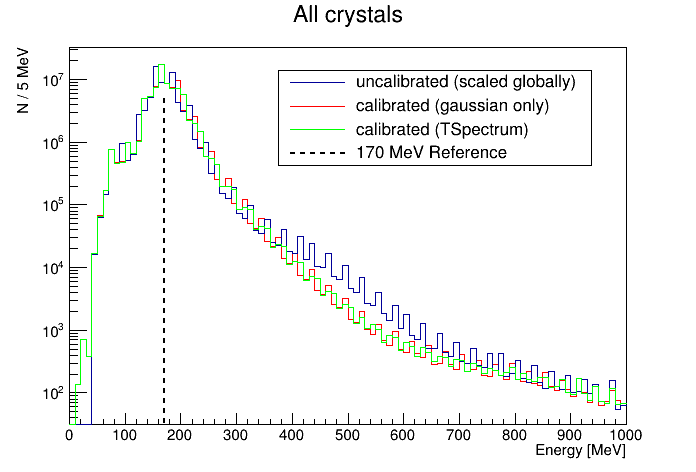

In [61]:
calibratedXtals.SetLineColor(2);
c1 = r.TCanvas("c1","c1",700,500);
leg1 = r.TLegend(0.4,0.65,0.85,0.85);
leg1.AddEntry(uncalibratedAllXtals,"uncalibrated (scaled globally)","l");
leg1.AddEntry(calibratedXtals,"calibrated (gaussian only)","l");
leg1.AddEntry(calibratedXtalsFinal,"calibrated (TSpectrum)","l");
calibratedXtals.Draw("hist");
uncalibratedAllXtals.Draw("hist same");
calibratedXtalsFinal.Draw("hist same");


line1 = r.TLine( 170., 0, 170. , 5*10**6);
line1.SetLineColorAlpha(1,1);
line1.SetLineWidth(2)
line1.SetLineStyle(7)
line1.Draw("SAME")
leg1.AddEntry(line1,"170 MeV Reference","l");

leg1.Draw();

c1.Draw()
c1.SetLogy()
c1.Print("./images/calibrationComparison.png");

In [62]:
print("Gaussian Mean:", calibratedXtals.GetMean(1))
print("TSpectrum Mean:", calibratedXtalsFinal.GetMean(1))

Gaussian Mean: 173.4933026621153
TSpectrum Mean: 174.3430549143955



****************************************
Minimizer is Linear
Chi2                      =      2.11494
NDf                       =         1294
p0                        =     0.988663   +/-   0.00536631  
p1                        =   0.00262657   +/-   0.00140031  


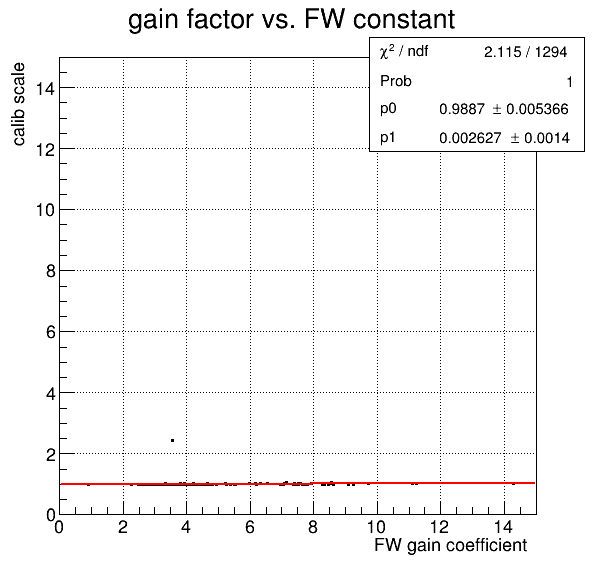

In [63]:
calibGain = r.TGraph();
for k in range(0, len(laserConstants)):
    #if(k%100 == 0):
    #    print("point", k)
    #//std::cout<< "laser "<<laserConstants.at(k) << std::endl;
    #//std::cout<< "calib "<<scales.at(k) << std::endl;
    calibGain.SetPoint(k, 1.0 / laserConstants[k], 1.0 / scales[k]);

c3 = r.TCanvas("c3","c3",600,600);
calibGain.SetTitle("gain factor vs. FW constant; FW gain coefficient; calib scale");
calibGain.SetMarkerStyle(7);
calibGain.Draw("apz");
calibGain.Fit("pol1")
calibGain.GetXaxis().SetRangeUser(0,15)
calibGain.GetYaxis().SetRangeUser(0,15)
c3.SetGrid()
c3.Draw();


In [64]:
for xtal, value in enumerate(scales):
    if(value == 1.0 or value == np.nan):
        print("Problem xtal:", xtal, "( calo", int(np.ceil(xtal/54)), "xtal", xtal%54,")")

Problem xtal: 758 ( calo 15 xtal 2 )


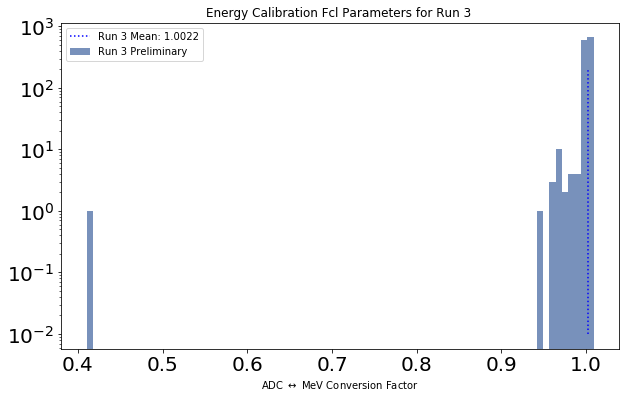

In [73]:
fig,ax = plt.subplots(figsize=(10,6))
plotbins = 80
plotrange = (0,1)


plt.hist(scales, label="Run 3 Preliminary",bins=plotbins, alpha=0.6, color="xkcd:cobalt")
plt.plot([np.mean(scales), np.mean(scales)], [0.01,200], "b:",label="Run 3 Mean: "+str(round(np.mean(scales),4)))


plt.title("Energy Calibration Fcl Parameters for Run 3 ")
plt.xlabel(r"ADC $\leftrightarrow$ MeV Conversion Factor")
#plt.ylabel("N")

#plt.ylim(0.9,300)

plt.legend()

plt.yscale("log")
plt.show()

---

### Quick comparison to run2 values

In [65]:
run2ScalesByCalo = [[np.nan for i in range(54)] for j in range(24) ]
run2Scales = []
with open("./data/mipEnergyCalibration23609.fcl") as file:
    for line in file:
        if("calo" in line):
            calo = int(line.split("calo")[1].split(" ")[0])
        if("xtal" in line):
            xtal = int(line.split("xtal")[1].split(" ")[0])
            constant = float(line.split("xtal")[1].split(" ")[2][:-1])
            run2ScalesByCalo[calo-1][xtal] = constant
            run2Scales.append(constant)

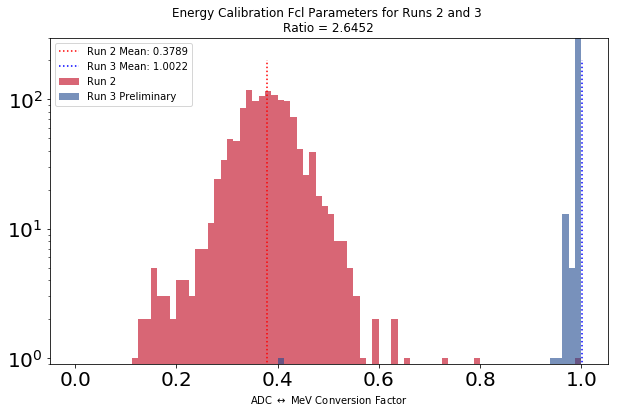

In [66]:
fig,ax = plt.subplots(figsize=(10,6))
plotbins = 80
plotrange = (0,1)

plt.hist(run2Scales,label="Run 2",bins=plotbins, range=plotrange, alpha=0.6, color="xkcd:scarlet")
plt.plot([np.mean(run2Scales), np.mean(run2Scales)], [0.01,200], "r:",label="Run 2 Mean: "+str(round(np.mean(run2Scales),4)))

plt.hist(scales, label="Run 3 Preliminary",bins=plotbins, range=plotrange, alpha=0.6, color="xkcd:cobalt")
plt.plot([np.mean(scales), np.mean(scales)], [0.01,200], "b:",label="Run 3 Mean: "+str(round(np.mean(scales),4)))


plt.title("Energy Calibration Fcl Parameters for Runs 2 and 3 \n"+"Ratio = "+str(round(np.mean(scales)/np.mean(run2Scales),4)))
plt.xlabel(r"ADC $\leftrightarrow$ MeV Conversion Factor")
#plt.ylabel("N")

plt.ylim(0.9,300)

plt.legend()

plt.yscale("log")
plt.show()

In [67]:
print("Mean run2:", np.mean(run2Scales))
print("Mean run3:", np.mean(scales))
print("Ratio:", np.mean(scales)/np.mean(run2Scales))

Mean run2: 0.3788672839506173
Mean run3: 1.0021909493885726
Ratio: 2.6452295878870373


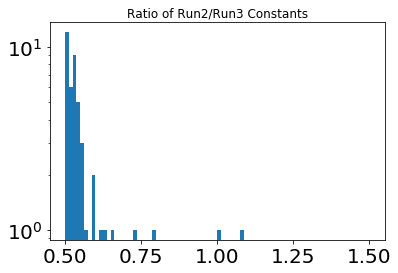

In [68]:
diffScales = [x/y for x,y in zip(run2Scales, scales)]
plt.hist(diffScales,bins=80,range=(0.5,1.5))
plt.yscale("log")
plt.title("Ratio of Run2/Run3 Constants")
plt.show()

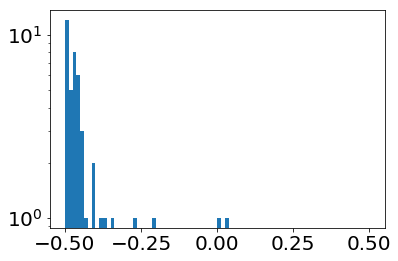

In [69]:
diffScales = [x-y for x,y in zip(run2Scales, scales)]
plt.hist(diffScales,bins=80,range=(-.5,.5))
plt.yscale("log")
plt.show()

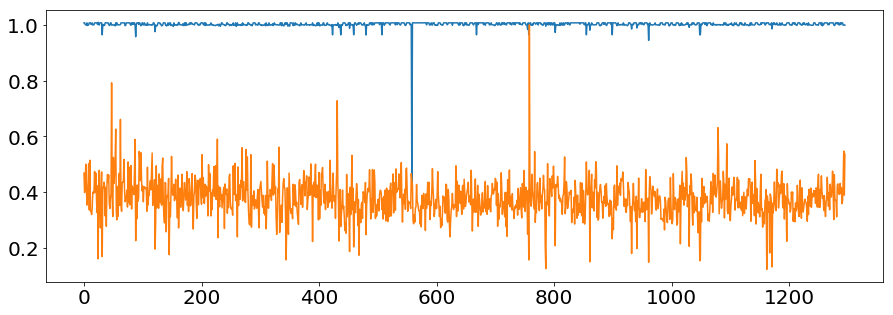

In [70]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(scales)
plt.plot(run2Scales)
plt.show()